In [1]:
# This example demonstrates quantum teleportation using qstack.
# Quantum teleportation is a protocol that transfers the state of a qubit to another qubit using entanglement and classical communication.
# The clifford_min layer is a minimal abstraction layer for Clifford operations, providing essential gates like H, CX, and Pauli gates.
# It is designed for efficient simulation and execution of quantum programs.
import random

from qstack.layers.cliffords_min import *
from qstack.layer import ClassicDefinition, QubitId, Kernel
from qstack import Program, Stack, Kernel
from qstack.classic_processor import ClassicalContext

# Randomly select an operation (X or H) for state preparation.
op = random.choice([X, H])


# Define a classical callback for state preparation.
def prepare(context: ClassicalContext, *, q: QubitId):
    return Kernel(targets=[], instructions=[op(q)])


# Define a classical callback for fixing the teleported state based on measurement outcomes.
def fix(context: ClassicalContext, *, q: QubitId):
    m0 = context.consume()  # Consume the first measurement result.
    m1 = context.consume()  # Consume the second measurement result.

    instructions = []
    if m1 == 1:
        instructions.append(Z(q))  # Apply a Z gate if the second measurement is 1.
    if m0 == 1:
        instructions.append(X(q))  # Apply an X gate if the first measurement is 1.

    return Kernel(targets=[], instructions=instructions)


# Extend the layer with classical definitions for Prepare and Fix operations.
Prepare = ClassicDefinition.from_callback(prepare)
Fix = ClassicDefinition.from_callback(fix)

teleport_layer = layer.extend_with(classic={Prepare, Fix})
stack = Stack.create(teleport_layer)


In [2]:
# Define the qubits involved in the teleportation protocol.
source = QubitId("source")  # The qubit whose state will be teleported.
shared = QubitId("shared")  # The entangled qubit shared between sender and receiver.
target = QubitId("target")  # The qubit that will receive the teleported state.

# Define the quantum program for teleportation.
program = Program(
    stack=stack,
    kernels=[
        Kernel.allocate(
            target,
            compute=[
                Kernel.allocate(
                    shared,
                    source,
                    compute=[
                        Kernel.continue_with(Prepare(q=source)),  # Prepare the source qubit.
                        H(shared),  # Create entanglement between shared and target qubits.
                        CX(shared, target),  # Entangle shared and target qubits.
                        CX(source, shared),  # Perform a Bell-state measurement.
                        H(source),  # Apply a Hadamard gate to the source qubit.
                    ],
                    continue_with=Fix(q=target),  # Fix the target qubit's state based on measurements.
                ),
            ],
        )
    ],
)

# Print the program to visualize its structure.
print(program)


@stack: cliffords-min.extended

allocate target:
  allocate shared source:
    ---
    ?? prepare(q=source)
    h shared
    cx shared target
    cx source shared
    h source
  measure
  ?? fix(q=target)
measure


In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for

machine = local_machine_for(program.stack)


In [4]:
# Print the name of the operation used for state preparation.
print(op.name)

# A single-shot execution runs the program once and returns the measurement outcomes.
# This is useful for observing the result of a single execution of the quantum program.
# Perform a single-shot execution of the teleportation protocol.
machine.single_shot(program)


x


(1,)

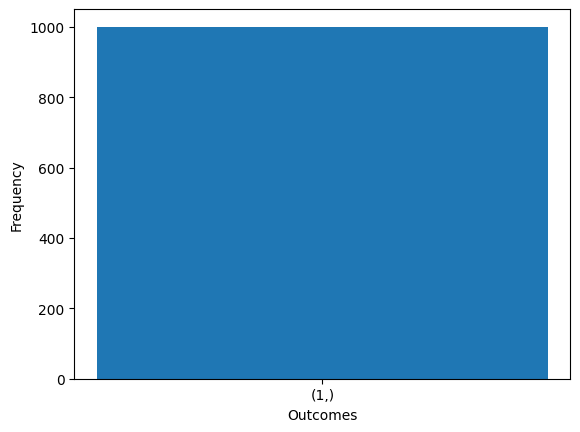

In [5]:
# Evaluate the program multiple times and plot the resulting histogram.
machine.eval(program).plot_histogram()
